In [1]:
# running coare3.6
import sys
import numpy as np
sys.path.append('/Users/katiekohlman/Desktop/MOTIVE/coare/')  # Replace with actual path
import coare36vn_zrf_et as c36
import coare36vnWarm_et as cwarm
import os

# reading and saving data
import pandas as pd
import re
import pandas as pd
import xarray as xr



In [9]:
adcp_path = '/Volumes/external/TIW/data/saildrone/processed_adcp/2017_SD1005_adcp_10min.nc'
adcp_ds = xr.open_dataset(adcp_path)

In [16]:
curr_spd = np.sqrt(adcp_ds.sel(depth=5,method='nearest').U**2 + adcp_ds.sel(depth=0,method='nearest').V**2)

In [23]:
sd_path = '/Volumes/external/TIW/data/saildrone/2017/1min/TPOS-2017_SD1005_1min.nc'
sd_ds = xr.open_dataset(sd_path)

In [24]:
# Ensure time is a coordinate
if "time" in sd_ds and "time" not in sd_ds.coords:
    sd_ds = sd_ds.set_coords("time")

# Ensure time is indexed
if "time" in sd_ds and "time" not in sd_ds.dims:
    sd_ds = sd_ds.swap_dims({"row": "time"})  # Replace 'row' with the actual dimension name


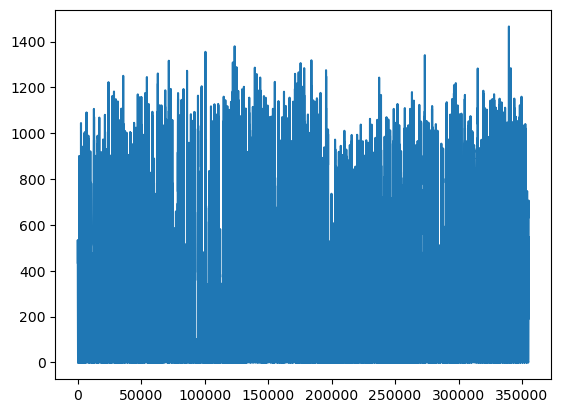

In [22]:
import matplotlib.pyplot as plt
plt.plot(sd_ds['SW'])

In [29]:
xr.open_dataset('/Users/katiekohlman/Desktop/Saildrone/Data/SD-PMEL-TPOS-2017-01/coare/TPOS2017Saildrone1005curf.cdf')

<xarray.Dataset> Size: 10MB
Dimensions:    (T10MIN: 35208)
Coordinates:
  * T10MIN     (T10MIN) datetime64[ns] 282kB 2017-09-03T12:00:00 ... 2018-05-...
Data variables: (12/34)
    LON        (T10MIN) float64 282kB ...
    LAT        (T10MIN) float64 282kB ...
    SST        (T10MIN) float64 282kB ...
    SW         (T10MIN) float64 282kB ...
    LW         (T10MIN) float64 282kB ...
    SLP        (T10MIN) float64 282kB ...
    ...         ...
    TWARM      (T10MIN) float64 282kB ...
    USR        (T10MIN) float64 282kB ...
    UWND       (T10MIN) float64 282kB ...
    VWND       (T10MIN) float64 282kB ...
    TAIR       (T10MIN) float64 282kB ...
    RH         (T10MIN) float64 282kB ...
Attributes:
    history:      PyFerret V7.5 (optimized) 19-Mar-21
    Conventions:  CF-1.6

In [ ]:
Jd = pd.to_datetime(sd_ds['time'].values).to_julian_date().values
U = sd_ds['WIND_SPEED_MEAN'].values - sd_ds['WATER_CURRENT_SPEED_MEAN'].values
Zu = sd_ds['WIND_MEASUREMENT_HEIGHT_MEAN'].values
Tair = sd_ds['TEMP_AIR_MEAN'].values
RH = sd_ds['RH_MEAN'].values
P = sd_ds['BARO_PRES_MEAN'].values
Tsea = sd_ds['TEMP_DEPTH_HALFMETER_MEAN'].values
SW_dn = sd_ds['SW_IRRAD_TOTAL_MEAN'].values
SW_dn = np.nan_to_num(SW_dn, nan=np.nanmean(SW_dn))  

LW_dn = np.full_like(U, 400)  # Convert scalar 0 to an array
Lat = sd_ds['latitude'].values
Lon = sd_ds['longitude'].values
Ss = sd_ds['SAL_SBE37_MEAN'].values


def interpolate_nan(array):
    """Interpolates NaN values in a 1D NumPy array using pandas."""
    series = pd.Series(array)
    return series.interpolate(method="linear", limit_direction="both").to_numpy()

U = interpolate_nan(U)
Zu = interpolate_nan(Zu)
Tair = interpolate_nan(Tair)
RH = interpolate_nan(RH)
P = interpolate_nan(P)
Tsea = interpolate_nan(Tsea)
Ss = interpolate_nan(Ss)

# Scalars turned into arrays with same length as U
length = len(U)
Zt = np.full(length, 2.3)
Zq = np.full(length, 2.3)
Zi = np.full(length, 1e-6)   # Small nonzero value
Rainrate = np.full(length, 0)
Ts_depth = np.full(length, 0.5)
cp = np.full(length, 0)
sigH = np.full(length, 0)
zrf_u = 10
zrf_t = 10
zrf_q = 10

In [ ]:
A=cwarm.coare36vnWarm_et(Jd, U, Zu, Tair, Zt, RH, Zq, P, Tsea, SW_dn, LW_dn, Lat, Lon, Zi, Rainrate, Ts_depth, Ss, None, None, zrf_u, zrf_t, zrf_q)


In [ ]:
x,usr, tau, hsb, hlb, hbb, hlwebb, tsr, qsr, zo, zot, zoq, Cd, Ch, Ce, L, zeta, dT_skinx, dq_skinx, dz_skin, Urf, Trf, Qrf, \
RHrf, UrfN, TrfN, QrfN, lw_net, sw_net, Le, rhoa, UN, U10, U10N, Cdn_10, Chn_10, Cen_10, hrain, Qs, Evap, T10, T10N, Q10, \
Q10N, RH10, P10, rhoa10, gust, wc_frac, Edis, dT_warm, dz_warm, dT_warm_to_skin, du_warm = A.T  # unpack the columns

In [ ]:
import xarray as xr
import numpy as np

# Assuming A is a numpy array with each column corresponding to a variable
# You might need to extract each column if it isn't already structured as you want
x,usr, tau, hsb, hlb, hbb, hlwebb, tsr, qsr, zo, zot, zoq, Cd, Ch, Ce, L, zeta, dT_skinx, dq_skinx, dz_skin, Urf, Trf, Qrf, \
RHrf, UrfN, TrfN, QrfN, lw_net, sw_net, Le, rhoa, UN, U10, U10N, Cdn_10, Chn_10, Cen_10, hrain, Qs, Evap, T10, T10N, Q10, \
Q10N, RH10, P10, rhoa10, gust, wc_frac, Edis, dT_warm, dz_warm, dT_warm_to_skin, du_warm = A.T  # unpack the columns

# Create an xarray Dataset
data_vars = {
    'usr': ('time', usr),
    'dT_warm': ('time', dT_warm),
    'dz_warm': ('time', dz_warm),
    'dT_warm_to_skin': ('time', dT_warm_to_skin),
    'du_warm': ('time', du_warm)
}

# Create an xarray Dataset
ds = xr.Dataset(data_vars)

# Add a time dimension (assuming the length of A corresponds to the time dimension)
ds.coords['time'] = ('time', Jd)

# Save to NetCDF
output_filename = "/Users/katiekohlman/Desktop/TIW/jupyter_notebooks/coare-output/coare_output_test.nc"
ds.to_netcdf(output_filename)

print(f"Dataset saved to {output_filename}")


# old and working for 2024

In [102]:
# running coare3.6
import sys
import numpy as np
sys.path.append('/Users/katiekohlman/Desktop/MOTIVE/coare/')  # Replace with actual path
import coare36vn_zrf_et as c36
import coare36vnWarm_et as cwarm
import os

# reading and saving data
import pandas as pd
import re
import pandas as pd
import xarray as xr



In [198]:
# prep data from saildrone
main_data_path = '/Users/katiekohlman/Desktop/Saildrone/Data/SD-PMEL-TPOS-2024-01/'
sd_nc_name = 'TPOS-2024_SD1033_1min.nc'

sd_path = main_data_path+sd_nc_name

start_date = np.datetime64("2024-11-21")
end_date = np.datetime64("2024-11-28")
sd_ds = xr.open_dataset(sd_path)

# Ensure time is a coordinate
if "time" in sd_ds and "time" not in sd_ds.coords:
    sd_ds = sd_ds.set_coords("time")

# Ensure time is indexed
if "time" in sd_ds and "time" not in sd_ds.dims:
    sd_ds = sd_ds.swap_dims({"row": "time"})  # Replace 'row' with the actual dimension name

#sd_ds = sd_ds.sel(time=slice(start_date, end_date)) # subsample

In [199]:
Jd = pd.to_datetime(sd_ds['time'].values).to_julian_date().values
U = sd_ds['WIND_SPEED_MEAN'].values - sd_ds['WATER_CURRENT_SPEED_MEAN'].values
Zu = sd_ds['WIND_MEASUREMENT_HEIGHT_MEAN'].values
Tair = sd_ds['TEMP_AIR_MEAN'].values
RH = sd_ds['RH_MEAN'].values
P = sd_ds['BARO_PRES_MEAN'].values
Tsea = sd_ds['TEMP_DEPTH_HALFMETER_MEAN'].values
SW_dn = sd_ds['SW_IRRAD_TOTAL_MEAN'].values
SW_dn = np.nan_to_num(SW_dn, nan=np.nanmean(SW_dn))  

LW_dn = np.full_like(U, 400)  # Convert scalar 0 to an array
Lat = sd_ds['latitude'].values
Lon = sd_ds['longitude'].values
Ss = sd_ds['SAL_SBE37_MEAN'].values


def interpolate_nan(array):
    """Interpolates NaN values in a 1D NumPy array using pandas."""
    series = pd.Series(array)
    return series.interpolate(method="linear", limit_direction="both").to_numpy()

U = interpolate_nan(U)
Zu = interpolate_nan(Zu)
Tair = interpolate_nan(Tair)
RH = interpolate_nan(RH)
P = interpolate_nan(P)
Tsea = interpolate_nan(Tsea)
Ss = interpolate_nan(Ss)

# Scalars turned into arrays with same length as U
length = len(U)
Zt = np.full(length, 2.3)
Zq = np.full(length, 2.3)
Zi = np.full(length, 1e-6)   # Small nonzero value
Rainrate = np.full(length, 0)
Ts_depth = np.full(length, 0.5)
cp = np.full(length, 0)
sigH = np.full(length, 0)
zrf_u = 10
zrf_t = 10
zrf_q = 10

In [200]:
A=cwarm.coare36vnWarm_et(Jd, U, Zu, Tair, Zt, RH, Zq, P, Tsea, SW_dn, LW_dn, Lat, Lon, Zi, Rainrate, Ts_depth, Ss, None, None, zrf_u, zrf_t, zrf_q)


WarmCoolLayer


/Users/katiekohlman/Desktop/MOTIVE/coare/coare36vn_zrf_et.py:750: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/Users/katiekohlman/Desktop/MOTIVE/coare/coare36vn_zrf_et.py:715: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43
/Users/katiekohlman/Desktop/MOTIVE/coare/coare36vn_zrf_et.py:700: RuntimeWarning: invalid value encountered in sqrt
  QN = Q + np.multiply(np.multiply(psiT,1000.0),qsr) / von / np.sqrt(gf)
/Users/katiekohlman/Desktop/MOTIVE/coare/coare36vn_zrf_et.py:769: RuntimeWarning: overflow encountered in exp
  psi = - (a * zeta + np.multiply(b * (zeta - c / d),np.exp(- dzeta)) + b * c / d)
/Users/katiekohlman/Desktop/MOTIVE/coare/coare36vn_zrf_et.py:750: RuntimeWarning: overflow encountered in exp
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/Users/katiekohlman/Desktop/M

In [203]:
x,usr, tau, hsb, hlb, hbb, hlwebb, tsr, qsr, zo, zot, zoq, Cd, Ch, Ce, L, zeta, dT_skinx, dq_skinx, dz_skin, Urf, Trf, Qrf, \
RHrf, UrfN, TrfN, QrfN, lw_net, sw_net, Le, rhoa, UN, U10, U10N, Cdn_10, Chn_10, Cen_10, hrain, Qs, Evap, T10, T10N, Q10, \
Q10N, RH10, P10, rhoa10, gust, wc_frac, Edis, dT_warm, dz_warm, dT_warm_to_skin, du_warm = A.T  # unpack the columns

In [204]:
Tfdn = Tsea - dT_warm + dT_warm*(0.5/dz_warm)

In [205]:
# Create xarray Dataset
ds = xr.Dataset(
    {
        "U": (["time"], U),
        "Zu": (["time"], Zu),
        "Tair": (["time"], Tair),
        "RH": (["time"], RH),
        "P": (["time"], P),
        "Tsea": (["time"], Tsea),
        "SW_dn": (["time"], SW_dn),
        "LW_dn": (["time"], LW_dn),
        "Lat": (["time"], Lat),
        "Lon": (["time"], Lon),
        "Ss": (["time"], Ss),
        "Zt": (["time"], Zt),
        "Zq": (["time"], Zq),
        "Zi": (["time"], Zi),
        "Rainrate": (["time"], Rainrate),
        "Ts_depth": (["time"], Ts_depth),
        "cp": (["time"], cp),
        "sigH": (["time"], sigH),
        "dT_warm": (["time"], dT_warm),
        "dz_warm": (["time"], dz_warm),
        "Tfdn": (["time"], Tfdn),
    },
    coords={"time": Jd},
)

# Display dataset
print(ds)

ds.to_netcdf("/Users/katiekohlman/Desktop/Saildrone/Data/SD-PMEL-TPOS-2024-01/coare/coare_warm_sd1033.nc")


<xarray.Dataset> Size: 25MB
Dimensions:   (time: 141002)
Coordinates:
  * time      (time) float64 1MB 2.461e+06 2.461e+06 ... 2.461e+06 2.461e+06
Data variables: (12/21)
    U         (time) float64 1MB 6.389 6.385 6.382 6.378 ... 4.823 4.823 4.823
    Zu        (time) float64 1MB 5.178 5.177 5.177 5.176 ... 5.116 5.116 5.116
    Tair      (time) float64 1MB 28.16 28.15 28.15 28.14 ... 26.14 26.12 26.19
    RH        (time) float64 1MB 83.63 83.68 83.73 83.78 ... 87.4 87.74 87.89
    P         (time) float64 1MB 1.009e+03 1.009e+03 ... 1.009e+03 1.009e+03
    Tsea      (time) float64 1MB 28.74 28.74 28.74 28.74 ... 27.15 27.14 27.14
    ...        ...
    Ts_depth  (time) float64 1MB 0.5 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    cp        (time) int64 1MB 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    sigH      (time) int64 1MB 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    dT_warm   (time) float64 1MB 0.0 0.0 0.0 0.0 ... 0.3158 0.317 0.3183 0.32
    dz_warm   (tim

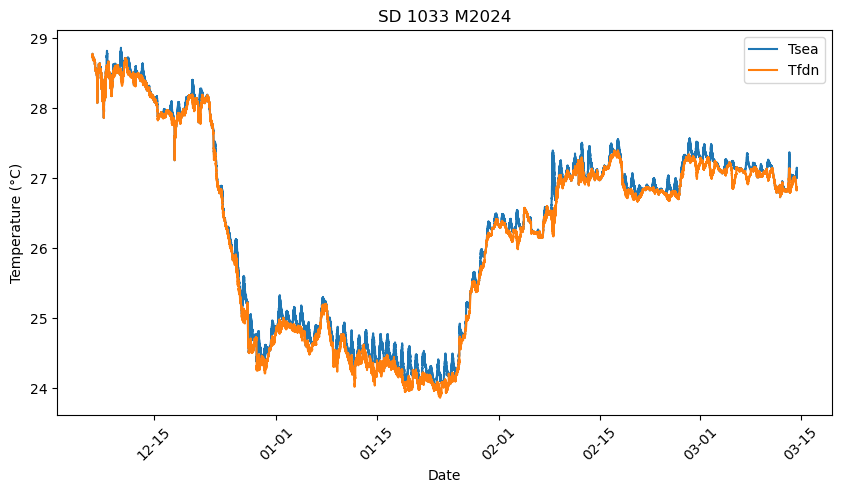

In [206]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Jd, Tsea, label="Tsea")
ax.plot(Jd, Tfdn, label="Tfdn")

# Format the x-axis ticks  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose appropriate tick locations
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format as 'YYYY-MM-DD'

# Rotate the x-axis labels for better readability  
plt.xticks(rotation=45)

# Labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("SD 1033 M2024")
ax.legend()

# Show the plot
plt.show()


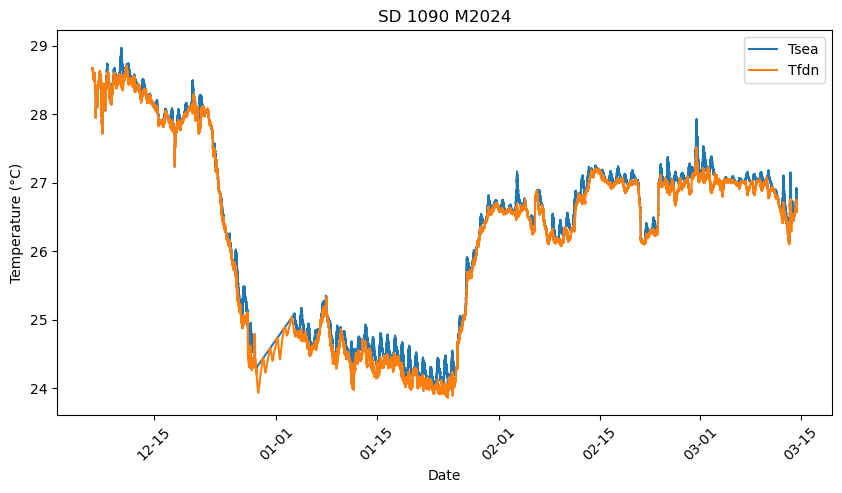

In [196]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Jd, Tsea, label="Tsea")
ax.plot(Jd, Tfdn, label="Tfdn")

# Format the x-axis ticks  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose appropriate tick locations
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format as 'YYYY-MM-DD'

# Rotate the x-axis labels for better readability  
plt.xticks(rotation=45)

# Labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("SD 1090 M2024")
ax.legend()

# Show the plot
plt.show()


In [193]:
len(Tfdn)

141002

In [192]:
sd_ds

<xarray.Dataset> Size: 91MB
Dimensions:                         (time: 141002)
Coordinates:
  * time                            (time) datetime64[ns] 1MB 2024-10-28T22:0...
Data variables: (12/80)
    latitude                        (time) float64 1MB 10.37 10.37 ... 5.377
    longitude                       (time) float64 1MB -125.1 -125.1 ... -140.4
    SOG                             (time) float64 1MB ...
    SOG_FILTERED_MEAN               (time) float64 1MB ...
    SOG_FILTERED_STDDEV             (time) float64 1MB ...
    SOG_FILTERED_MAX                (time) float64 1MB ...
    ...                              ...
    CDOM_STDDEV                     (time) float64 1MB ...
    BKSCT_RED_MEAN                  (time) float64 1MB ...
    BKSCT_RED_STDDEV                (time) float64 1MB ...
    WATER_CURRENT_SPEED_MEAN        (time) float64 1MB 0.339 0.365 ... 0.39
    WATER_CURRENT_DIRECTION_MEAN    (time) float64 1MB ...
    trajectory                      (time) object 1MB ...
Attributes: (12/67)
    acknowledgement:                     If you use these Saildrone Tropical ...
    area:                                GO-USV repeat meridional and zonal s...
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Zhang et al. (2019) when...
    contributor_email:                   nathan.anderson@noaa.gov; dongxiao.z...
    ...                                  ...
    time_coverage_resolution:            PT1M
    time_coverage_start:                 2024-10-28T22:00:00Z
    time_in:                             minutes
    title:                               NOAA PMEL TPOS 2024 Saildrone 1090
    Westernmost_Easting:                 -149.609792
    wmo_id:                              1801606

In [125]:
import xarray as xr
import numpy as np

# Assuming A is a numpy array with each column corresponding to a variable
# You might need to extract each column if it isn't already structured as you want
x,usr, tau, hsb, hlb, hbb, hlwebb, tsr, qsr, zo, zot, zoq, Cd, Ch, Ce, L, zeta, dT_skinx, dq_skinx, dz_skin, Urf, Trf, Qrf, \
RHrf, UrfN, TrfN, QrfN, lw_net, sw_net, Le, rhoa, UN, U10, U10N, Cdn_10, Chn_10, Cen_10, hrain, Qs, Evap, T10, T10N, Q10, \
Q10N, RH10, P10, rhoa10, gust, wc_frac, Edis, dT_warm, dz_warm, dT_warm_to_skin, du_warm = A.T  # unpack the columns

# Create an xarray Dataset
data_vars = {
    'usr': ('time', usr),
    'dT_warm': ('time', dT_warm),
    'dz_warm': ('time', dz_warm),
    'dT_warm_to_skin': ('time', dT_warm_to_skin),
    'du_warm': ('time', du_warm)
}

# Create an xarray Dataset
ds = xr.Dataset(data_vars)

# Add a time dimension (assuming the length of A corresponds to the time dimension)
ds.coords['time'] = ('time', Jd)

# Save to NetCDF
output_filename = "/Users/katiekohlman/Desktop/TIW/jupyter_notebooks/coare-output/coare_output_test.nc"
ds.to_netcdf(output_filename)

print(f"Dataset saved to {output_filename}")


Dataset saved to /Users/katiekohlman/Desktop/TIW/jupyter_notebooks/coare-output/coare_output_test.nc


In [147]:
sd_ds

<xarray.Dataset> Size: 7MB
Dimensions:                         (time: 10082)
Coordinates:
  * time                            (time) datetime64[ns] 81kB 2024-11-21 ......
Data variables: (12/80)
    latitude                        (time) float64 81kB 1.43 1.43 ... 0.7118
    longitude                       (time) float64 81kB -136.0 -136.0 ... -137.6
    SOG                             (time) float64 81kB ...
    SOG_FILTERED_MEAN               (time) float64 81kB ...
    SOG_FILTERED_STDDEV             (time) float64 81kB ...
    SOG_FILTERED_MAX                (time) float64 81kB ...
    ...                              ...
    CDOM_STDDEV                     (time) float64 81kB ...
    BKSCT_RED_MEAN                  (time) float64 81kB ...
    BKSCT_RED_STDDEV                (time) float64 81kB ...
    WATER_CURRENT_SPEED_MEAN        (time) float64 81kB 0.238 0.226 ... 0.589
    WATER_CURRENT_DIRECTION_MEAN    (time) float64 81kB ...
    trajectory                      (time) object 81kB ...
Attributes: (12/67)
    acknowledgement:                     If you use these Saildrone Tropical ...
    area:                                GO-USV repeat meridional and zonal s...
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Zhang et al. (2019) when...
    contributor_email:                   nathan.anderson@noaa.gov; dongxiao.z...
    ...                                  ...
    time_coverage_resolution:            PT1M
    time_coverage_start:                 2024-10-28T22:00:00Z
    time_in:                             minutes
    title:                               NOAA PMEL TPOS 2024 Saildrone 1090
    Westernmost_Easting:                 -149.609792
    wmo_id:                              1801606

In [157]:
import xarray as xr
import numpy as np
import scipy.optimize as opt

# Constants
Ri_cr = 0.65  # Critical Richardson number
I = 86400  # Integration time (seconds)
g = 9.81  # Gravity (m/s^2)
Cp_oc = 3985  # Specific heat of seawater (J/kg*K)

# Extract relevant variables
gust = sd_ds["GUST_WND_MEAN"]  # Wind gust speed (m/s)
u=U
gust = interpolate_nan(gust)
SW=SW_dn





# Compute density (rho_oc) using UNESCO equation (approximate)
rho_oc = 1027 - 0.2 * (Tsea - 10) + 0.8 * (Ss - 35)  # Simplified approximation

# Compute alpha (thermal expansion coefficient)
dT = 0.1  # Small temperature step for finite difference
drho_dT = (1027 - 0.2 * ((Tsea + dT) - 10) + 0.8 * (Ss - 35)) - rho_oc
alpha = - (1 / rho_oc) * (drho_dT / dT)

# Function to compute f(D_T)
def f_DT(D_T):
    return (0.004 * (1 - np.exp(-D_T / 0.014)) +
            0.096 * (1 - np.exp(-D_T / 0.36)) +
            5.77 * (1 - np.exp(-D_T / 12.82))) / D_T

# Function to solve for D_T
def compute_DT(Q0, u_star, gust, rho, alpha_val):
    def equation(D_T):
        Qpen = Q0 * f_DT(D_T)
        return np.sqrt((2 * Ri_cr * rho * Cp_oc * I) / (alpha_val * g * (Q0 - Qpen))) * (u_star**2 + gust) - D_T
    
    D_T_solution = opt.fsolve(equation, 10)  # Initial guess of 10m
    return D_T_solution[0]

# Compute u_star (friction velocity), approximate as u_star ~ 0.035 * u
u_star = 0.035 * u

# Compute D_T element-wise
D_T_values = [compute_DT(Q0, u_s, g, r, a) for Q0, u_s, g, r, a in zip(SW, u_star, gust, rho_oc, alpha)]

#sd_ds["D_T"] = ("time", D_T_values)

# Save output
#sd_ds.to_netcdf("output_with_Dt.nc")

In [155]:
SW

array([693.3, 330.1, 447.8, ..., 675.9, 667.5, 670.8])